In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import re
import math
from datetime import datetime
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

from sklearn.feature_selection import RFE
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import learning_curve, GridSearchCV

In [2]:
# !pip install mlxtend
# !pip install lightgbm
# !pip install pymysql
# !pip install scikit-plot
# !pip install tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from autoscoring import IDF
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins

In [11]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

# df['date_requested'] = pd.to_datetime(df['date_requested'])
DATE = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df[DATE] = pd.to_datetime(df[DATE])
df_req = df[['credit_id', DATE]]
df['y'] = df['target']
y = df.y

In [6]:
# В некоторых случаях при загрузке из excel файла может произойти проблема,
# связанная с тем, что в excel вещественные числа разделяются запятой,
# а в python разделение идёт по точке.
# Если возникла такая проблема, то можно заменить все запятые на точки и сделать преобразование типовю

# Запускать эту ячейку, только если есть данная проблема. Иначе можно пропустить.

for col in df.select_dtypes(include=object).columns:
    df[col] = df[col].apply(lambda x: str(x).replace(',', '.'))

df = df.apply(pd.to_numeric, errors='ignore')

In [12]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [13]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
# Можно задать список признаков, который не будет учавствовать в предобработке
ignore_vars = ['date_requested', 'credit_id', 'target', DATE]
df, else_df = replace_not_frequent_2(df, cat_vars, num_min=min_num, ignore_vars=ignore_vars)

# Drop columns with only 1 value
df = drop_single_value_column(df, except_cols=ignore_vars)

In [14]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

df_out = df[df['date_requested'] >= '2021-01-01']
df = df[df['date_requested'] < '2021-01-01']
y_out = df_out.y

In [15]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

#### Построение WOE таблицы

In [16]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['credit_id', 'date_requested', 'type',
                        'target', 'y', DATE]
technical_features = list(set(technical_features))
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df_train.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = False
n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df_train, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный,
# также стоит отдельно смотреть, что может быть такая ситуация, что переменная не имеет хорошего 
# разделения, но NaN значения хорошо отделяются. Тогда стоит отдельно заполнять NaN некоторым эмпирическим значением.
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 474, number of negative: 5268
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19198
[LightGBM] [Info] Number of data points in the train set: 5742, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082550 -> initscore=-2.408199
[LightGBM] [Info] Start training from score -2.408199
ERROR in last days_from_fc_d_requested doesnt have information, [-2.235e+02  1.000e-05], 1


In [17]:
# Набор обязательных признаков, которые должны остаться несмотря на отбор.
mandatory_feats = ['credits_active_owner', 'credits_all_owner']
mandatory_feats_woe = ['WOE_' + col for col in mandatory_feats]

In [18]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.01
vars = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()
vars = add_mandatory_feats(vars, mandatory_feats)
print(len(vars))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(vars)]

143


In [19]:
iv_co = None
X_train, y_train = transform_df_to_woe(df_train[vars], y_train, IV, iv_df, iv_cut_off=iv_co)
X_test, y_test = transform_df_to_woe(df_test[vars], y_test, IV, iv_df, iv_cut_off=iv_co)
X_out, y_out = transform_df_to_woe(df_out[vars], y_out, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 143
DONE!
Features left after IV drop: 143
DONE!
Features left after IV drop: 143
DONE!


In [20]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

#### Отбор признаков

Dropped columns: [] 

Features left after correlation check: 143 

Not dropped columns: ['WOE_cnt_IL_comp_no_Crd', 'WOE_reg', 'WOE_fcb_last_open_d_cr_act', 'WOE_min_all_last_pay', 'WOE_gcvp_type_employee', 'WOE_fc_his_w_pay_st_by_cls_crd_sum', 'WOE_sum_per_cred', 'WOE_sum_all_credit_sum', 'WOE_pti5', 'WOE_r_reg', 'WOE_credit_purpose', 'WOE_avg_fr_age', 'WOE_h_ac_sum_div_h_cl_sum', 'WOE_bor_age', 'WOE_credits_all_owner', 'WOE_enpf_text', 'WOE_capsTotalAmountL1m', 'WOE_exists_income_for_3_month', 'WOE_fcb_first_Cash_credit', 'WOE_cnt_IL_comp', 'WOE_fc_act_div_all_crd', 'WOE_min_IL_planned_close_date', 'WOE_fc_his_w_pay_st_by_act_crd_sum', 'WOE_main_wall_postsN', 'WOE_fc_h_ac_sum_div_days', 'WOE_cnt_IL_past_due_no_Crd', 'WOE_centre_completed', 'WOE_dti5', 'WOE_fc_credits_all_owner', 'WOE_sex', 'WOE_fc_enpf_text', 'WOE_avg_photos_n', 'WOE_io_device_os', 'WOE_capsL1d_v2', 'WOE_fc_h_ac_sum_div_h_cl_sum', 'WOE_cnt_IL_all_no_Crd', 'WOE_fcb_last_open_d_cr_all', 'WOE_h_ac_sum_div_days', 'WOE_req

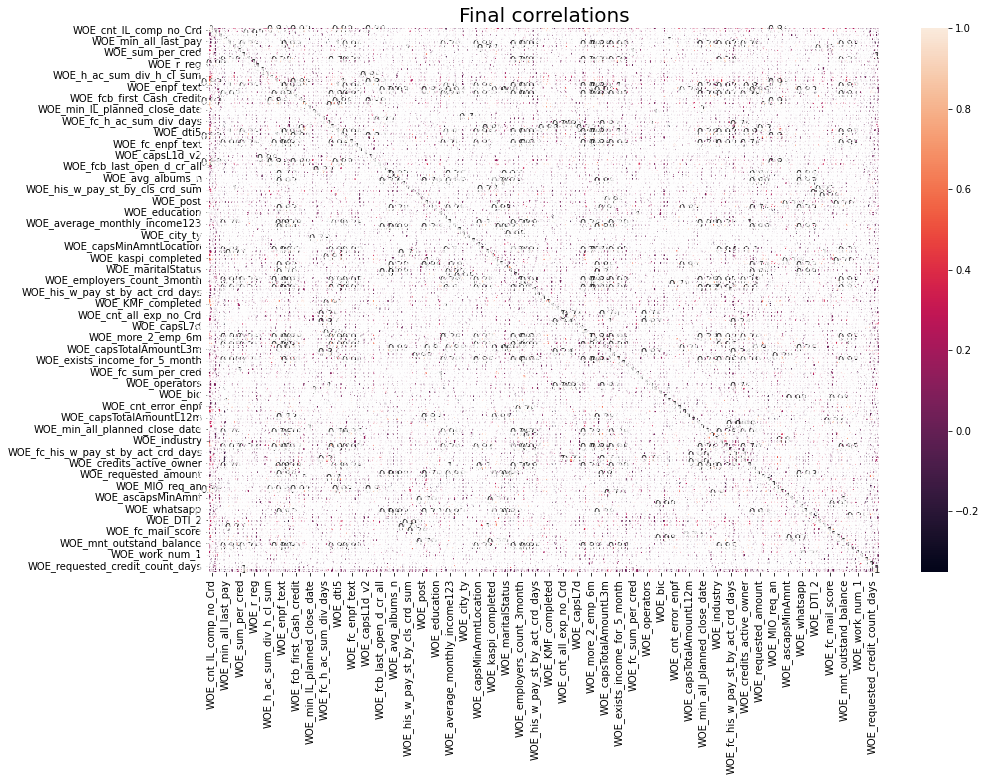

In [21]:
# Устанавливаем порого для фильтрации признаков по корреляциям.
# По дефолту 0.85 - оптимальное значение, в зависимости от требований
# можно поставить число в диапозоне 0.75 - 0.9.
cut_off = 0.85
X_train_corr = delete_correlated_features(X_train, cut_off=cut_off, is_plot_prev=False,
                                          exclude=[], IV_sort=True, iv_df=iv_df)

In [22]:
corr_feats = X_train_corr.columns

In [28]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по DATE (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества интервалов большего num_bad_intervals.
# Т.е. например, если gini_min=0.05 и num_bad_intervals=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_intervals = 2  # 2 месяца/недели по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week

gini_feats, df_gini_months = gini_month_selection(X_train[corr_feats], df_train, gini_min=gini_min,
                                                  num_bad_intervals=num_bad_intervals, date_name=date_name,
                                                  intervals=intervals)

In [29]:
print(len(list(gini_feats)))
df_gini_months[df_gini_months['vars'].isin(gini_feats)]

101


,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,WOE_cnt_IL_comp_no_Crd,0.119,0.033,0.287,0.196,0.182,0.335,0.264,0.368
1,WOE_reg,0.088,0.287,0.040,0.235,0.142,0.120,0.217,0.118
4,WOE_gcvp_type_employee,0.072,0.118,0.045,0.086,0.110,0.036,0.069,0.090
5,WOE_fc_his_w_pay_st_by_cls_crd_sum,0.077,0.000,0.077,0.142,0.023,0.077,0.136,0.322
6,WOE_sum_per_cred,0.092,0.022,0.039,0.178,0.273,0.097,0.152,0.188
...,...,...,...,...,...,...,...,...,...
135,WOE_mnt_outstand_balance,0.016,0.022,0.090,0.166,0.311,0.149,0.271,0.189
136,WOE_DTI_11,0.058,0.081,0.088,0.076,0.189,0.024,0.088,0.103
138,WOE_work_num_1,-0.018,0.091,0.131,0.130,0.082,0.154,0.249,0.217
139,WOE_capsL1d,0.107,-0.026,0.073,0.063,0.029,0.152,0.082,0.067


In [30]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 60  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X_train[gini_feats], y_train, top_n=top_n)

In [31]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 30  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X_train[rf_feats], y_train, top_n=top_n)

In [32]:
# Делаем итоговый отбор признаков, он вычислительно затратный и более точный.
n_features = 8  # количество признаков, оптимально 7 - 14, меньше - быстрее посчитается.
selection_type = 'bf'  # Тип перебора признаков, оптимальный вариант 'bf' можно выбрать 'ALL', если есть время подождать.
X_train_res, X_test_res, X_train_cp, X_test_cp = feature_selection(X_train[tf_feats], y_train, X_test[tf_feats], y_test,
                                                 n_features=n_features, selection_type=selection_type)

done included_00
done included_00


In [ ]:
# Сохраянем все пройденные этапы отбора признаков.
selection_stages = {
    'исходный набор': features,
    'WOE биннинг': iv_df['VAR_NAME'].unique(),
    'корреляции': corr_feats,
    'однофакторный gini по месяцам': gini_feats,
    'features importance деревьев решений': rf_feats,
    'permutation importance двухлесовый метод': tf_feats,
    'отбор функцией feature_selection("bf")': X_train_res.columns,
}
name = 'result/selection_stages.xlsx'
save_selection_stages(selection_stages, name)

In [50]:
vars_woe = list(X_train_res.columns)
vars_woe = add_mandatory_feats(vars_woe, mandatory_feats_woe)
print(vars_woe)

['WOE_last_deduction_date', 'WOE_work_amount', 'WOE_fc_sum_per_cred', 'WOE_credits_active_owner', 'WOE_cnt_IL_all', 'WOE_fcb_first_cred_open_act', 'WOE_credits_all_owner', 'WOE_mail_score', 'WOE_requested_amount_to_pay', 'WOE_maritalStatus']


In [34]:
# Создаём список переменных, для удобного ручного отбора,
# если ручной отбор не треубется, можно пропустить.
vars_woe = [
    # 'WOE_last_deduction_date',
    # 'WOE_mail_score',
    'WOE_requested_amount_to_pay',
    'WOE_cnt_IL_comp',  
    # 'WOE_work_amount',
    # 'WOE_MIO_req_an',
    'WOE_r_reg',
    'WOE_capsTotalAmountL7d',
    'WOE_NumberOfOverdueInstalmentsMax',
    # 'WOE_DTI_2',
    'WOE_fc_mail_score',
    'WOE_PTI_11',
    'WOE_fcb_first_cred_open_act'
]

#### Обучение логистической регрессии

In [35]:
df_train_m = X_train[vars_woe]
df_test_m = X_test[vars_woe]
df_out_m = X_out[vars_woe]

params = {
    'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
    'class_weight': {0: 1, 1: 4}, 'random_state': 142
}
# Обучаем модель на данных полученных после удаления аномалий.
logreg = LogisticRegression(**params).fit(df_train_m, y_train)

predict_proba_train = logreg.predict_proba(df_train_m)[:, 1]
predict_proba_test = logreg.predict_proba(df_test_m)[:, 1]
predict_proba_out = logreg.predict_proba(df_out_m)[:, 1]

Gini_train = round(2 * roc_auc_score(y_train, predict_proba_train) - 1, 3)
Gini_test = round(2 * roc_auc_score(y_test, predict_proba_test) - 1, 3)
Gini_out = round(2 * roc_auc_score(y_out, predict_proba_out) - 1, 3)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', Gini_train, '| Gini test =', Gini_test,  '| Gini out =', Gini_out, '|')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
| Gini train = 0.465 | Gini test = 0.43 | Gini out = 0.428 |
---------------------------------------------------------------------------------------------


#### Функции для ручного подбора признаков

In [ ]:
# Здесь требуется последовательно указать train, test, out выборки,
# если out - отсутствует, поставить None.
# При этом стоит указать не все признаки, а набор признаков после
# предварительного отбора - rf_feats, gini_feats
X_all = [X_train[rf_feats], X_test[rf_feats], X_out[rf_feats]]
y_all = [y_train, y_test, y_out]

# Считаем, что будет, если убрать один из признаков.
# Напротив каждого признака - gini модели после удаления этого признака.
df_var_ginis = feature_exclude(X_all, y_all, list(vars_woe), iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)

,var_name,gini_train,gini_test,gini_out,IV
1,WOE_requested_amount_to_pay,0.458299,0.432703,0.428938,0.2008
0,with all,0.465477,0.429549,0.428024,
8,WOE_fcb_first_cred_open_act,0.448421,0.423692,0.409312,0.0902
5,WOE_NumberOfOverdueInstalmentsMax,0.462829,0.422262,0.418720,0.1507
4,WOE_capsTotalAmountL7d,0.460214,0.418846,0.420327,0.2101
7,WOE_PTI_11,0.447004,0.418455,0.424884,0.1573
3,WOE_r_reg,0.452638,0.4123,0.397078,0.0987
2,WOE_cnt_IL_comp,0.440643,0.40069,0.405981,0.2469
6,WOE_fc_mail_score,0.444291,0.400481,0.440108,0.1008


In [ ]:
# Считаем, что будет, если добавить один из признаков.
# Напротив каждого признака - gini модели после добавления этого признака.
df_var_ginis = feature_include1(X_all, y_all, vars_woe, iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
3,WOE_last_deduction_date,0.501338,0.456015,0.388658,0.2448
32,WOE_monthly_instalments_owner,0.466722,0.436732,0.432810,0.1408
33,WOE_fc_monthly_instalments_owner,0.466722,0.436732,0.432810,0.1408
4,WOE_capsL12mas,0.467336,0.433851,0.426423,0.0217
16,WOE_capsMaxAmnt,0.468162,0.432595,0.426433,0.1721
9,WOE_r_city_ty,0.466274,0.431926,0.428750,0.0163
34,WOE_fc_h_ac_sum_div_days,0.47076,0.431837,0.427507,0.0263
15,WOE_cnt_IL_all,0.466556,0.431579,0.427349,0.2758
45,WOE_education,0.465816,0.431398,0.426442,0.0165
44,WOE_h_ac_sum_div_h_cl_sum,0.465977,0.430842,0.426383,0.0566


In [ ]:
# Считаем, что будет, если добавить сразу два признака.
# Напротив каждой пары признаков - gini модели после добавления этой пары.
df_var_ginis = feature_include2(X_all, y_all, vars_woe, iv_df, params)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
4,"WOE_last_deduction_date, WOE_capsL12mas",0.504532,0.462662,0.434027,"0.2448, 0.0217"
3,"WOE_fc_his_w_pay_st_by_act_crd_sum, WOE_last_d...",0.507226,0.453642,0.395424,"0.0326, 0.2448"
34,"WOE_fc_monthly_instalments_owner, WOE_fc_h_ac_...",0.47214,0.438927,0.435152,"0.1408, 0.0263"
33,"WOE_monthly_instalments_owner, WOE_fc_monthly_...",0.466725,0.43674,0.440300,0.1408
16,"WOE_cnt_IL_all, WOE_capsMaxAmnt",0.469152,0.43477,0.434258,"0.2758, 0.1721"
5,"WOE_capsL12mas, WOE_dependants_count",0.472375,0.43444,0.433356,"0.0433, 0.0217"
32,"WOE_avg_fr_age, WOE_monthly_instalments_owner",0.472934,0.433968,0.440300,"0.1408, 0.0822"
45,"WOE_h_ac_sum_div_h_cl_sum, WOE_education",0.466318,0.432957,0.434472,"0.0566, 0.0165"
40,"WOE_fc_mnt_outstand_balance, WOE_reg",0.468211,0.431451,0.435181,"0.1297, 0.0777"
41,"WOE_reg, WOE_mnt_outstand_balance",0.468211,0.431451,0.437515,"0.1297, 0.0777"


#### Построение графиков и таблиц для оценки результатов

Cross_val_scores:  [0.45623026 0.47337147 0.43423688 0.42343073 0.45286222]
ROC_AUC:   0.715
Gini Train: 0.465
Gini Test: 0.43
F1_score:  0.235
Log_loss:  4.002


Classification_report: 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      1626
           1       0.26      0.24      0.25       169

    accuracy                           0.87      1795
   macro avg       0.59      0.58      0.59      1795
weighted avg       0.86      0.87      0.86      1795

[array([-0.6135285 , -0.6915335 , -0.71140803, -0.50629492, -0.28735826,
       -0.83338616, -0.6735063 , -0.95648786]), -0.9562063834303179]


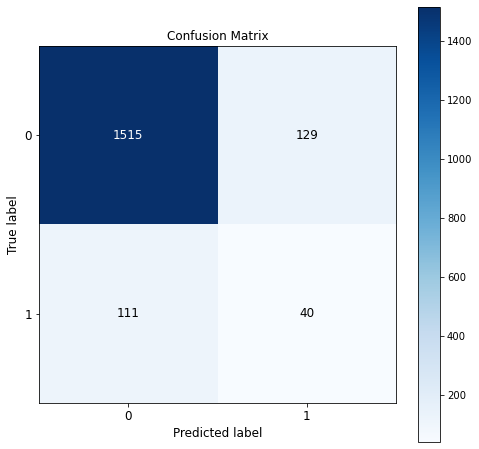

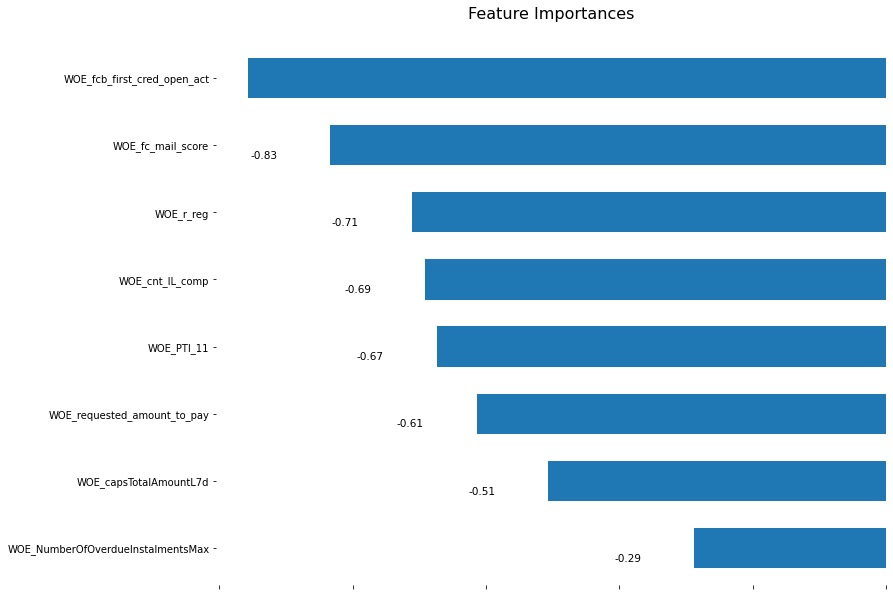

In [36]:
_X = np.vstack([X_train[vars_woe], X_test[vars_woe], X_out[vars_woe]])
_y = np.hstack([y_train, y_test, y_out])

_logreg = LogisticRegression(**params)
scores = list(map(lambda x: round(x, 3), 2 * cross_val_score(_logreg, _X, _y, cv=5, scoring='roc_auc') - 1))
print ('Cross_val_scores: ', scores)

_logreg = logreg
IDF.plot_score(_logreg, X_test[vars_woe], y_test, X_train[vars_woe], y_train, cut_off=0.45)
print([_logreg.coef_[0], _logreg.intercept_[0] ])

In [1]:
date_name = DATE  # имя столбца даты по которому делить на месяцы
intervals = 'month'  # грануляция по времени, возможно month и week
df3, feat = construct_df3(vars_woe, logreg, df_req, X_train, X_test, df_train, df_test,
                          X_out=X_out, df_out=df_out, date_name=date_name, intervals=intervals)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

NameError: name 'DATE' is not defined

In [2]:
Ginis = create_gini_stability(df3, logreg, X_train[vars_woe])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
period_date = 1  # Период с которым будут отображаться даты на графике
gini_stability_chart(Ginis, pic_folder=pic_folder, period_date=period_date)
score_stability_graph(table, pic_folder=pic_folder)

NameError: name 'create_gini_stability' is not defined

In [ ]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars_woe)

In [ ]:
gini_by_vars

,vars,gini_train,gini_test,gini_out
1,WOE_cnt_IL_comp,0.267,0.278,0.293
3,WOE_capsTotalAmountL7d,0.245,0.201,0.217
0,WOE_requested_amount_to_pay,0.243,0.185,0.208
6,WOE_PTI_11,0.2,0.153,0.076
4,WOE_NumberOfOverdueInstalmentsMax,0.188,0.197,0.246
2,WOE_r_reg,0.17,0.178,0.274
5,WOE_fc_mail_score,0.161,0.149,0.035
7,WOE_fcb_first_cred_open_act,0.137,0.145,0.164


In [39]:
# Считаем однофакторный gini по месяцам.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week.
_, df_gini_months = gini_month_selection(df3[vars_woe], df3, date_name=date_name, intervals=intervals)

In [ ]:
df_gini_months

,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
0,WOE_requested_amount_to_pay,0.196,0.275,0.222,0.327,0.328,0.192,0.186,0.192,0.214,0.198
1,WOE_cnt_IL_comp,0.178,0.074,0.325,0.238,0.306,0.306,0.262,0.346,0.330,0.249
2,WOE_r_reg,0.005,0.292,0.034,0.235,0.161,0.169,0.222,0.188,0.249,0.307
3,WOE_capsTotalAmountL7d,0.157,0.253,0.232,0.355,0.196,0.192,0.237,0.215,0.234,0.194
4,WOE_NumberOfOverdueInstalmentsMax,0.144,0.120,0.189,0.056,0.268,0.170,0.212,0.275,0.211,0.287
5,WOE_fc_mail_score,0.113,0.059,0.110,0.148,0.171,0.130,0.180,0.108,0.050,0.018
6,WOE_PTI_11,0.151,0.139,0.179,0.273,0.345,0.048,0.206,0.159,0.046,0.113
7,WOE_fcb_first_cred_open_act,0.158,0.220,0.116,0.150,0.115,0.120,0.105,0.163,0.093,0.249


In [40]:
# Create ivi to excel
ivs = ivs_to_excel(iv_df, X_train[vars_woe])

# Score and IV groups
ivs = iv_groups(ivs)
ivs = add_score(ivs, feat, y_train)

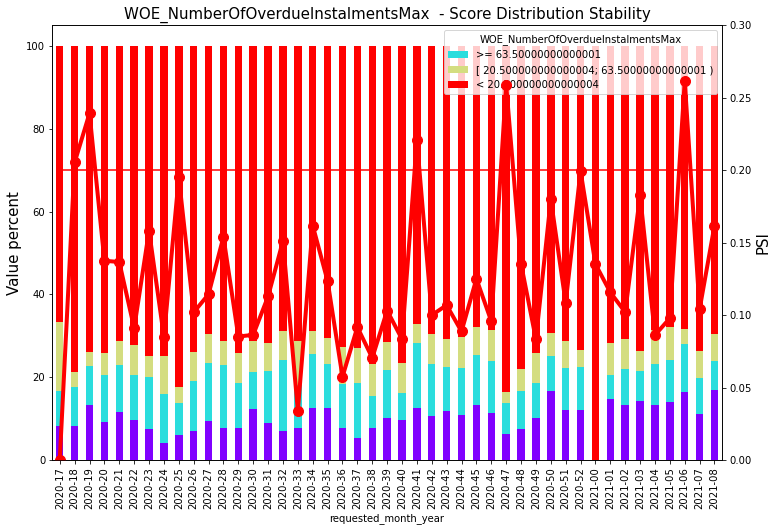

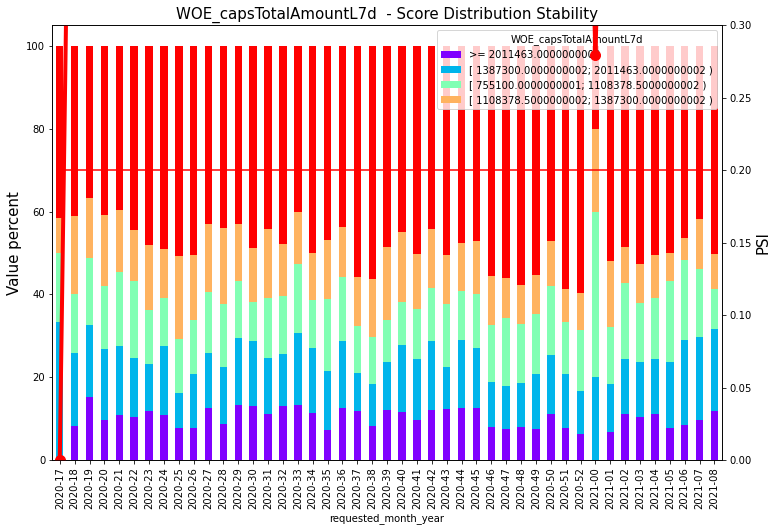

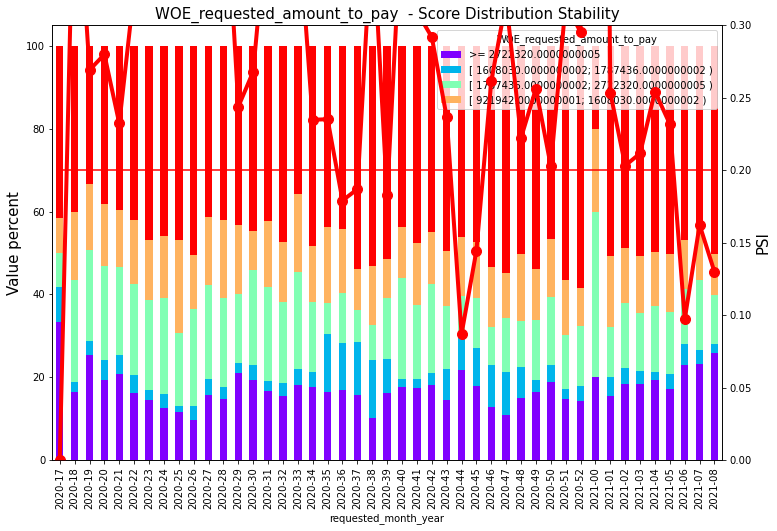

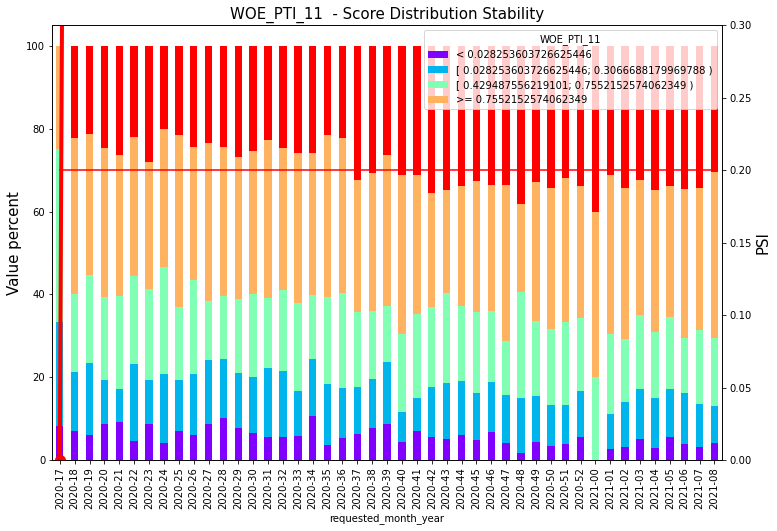

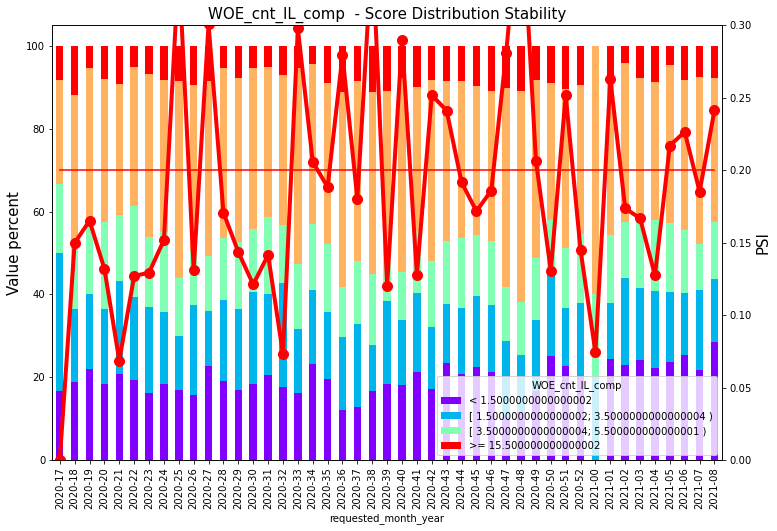

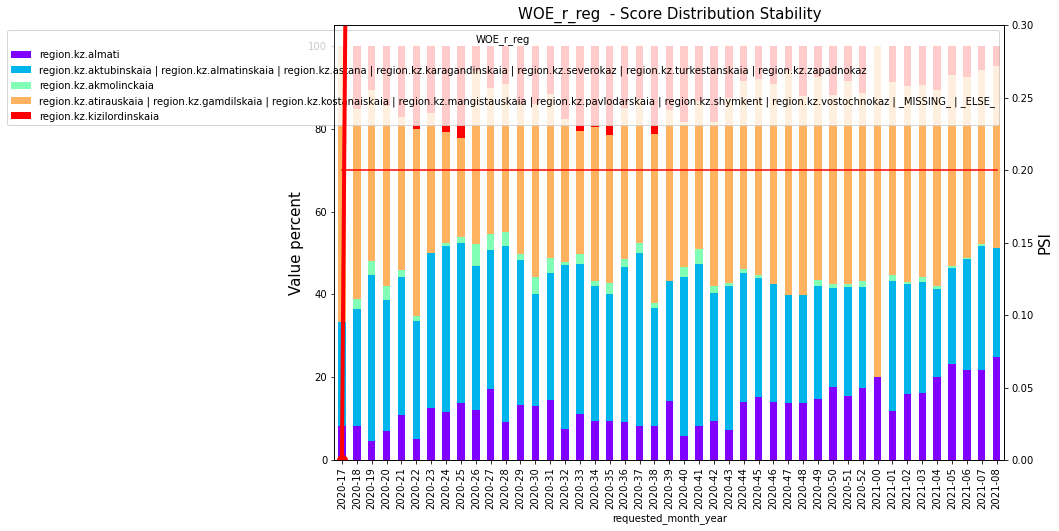

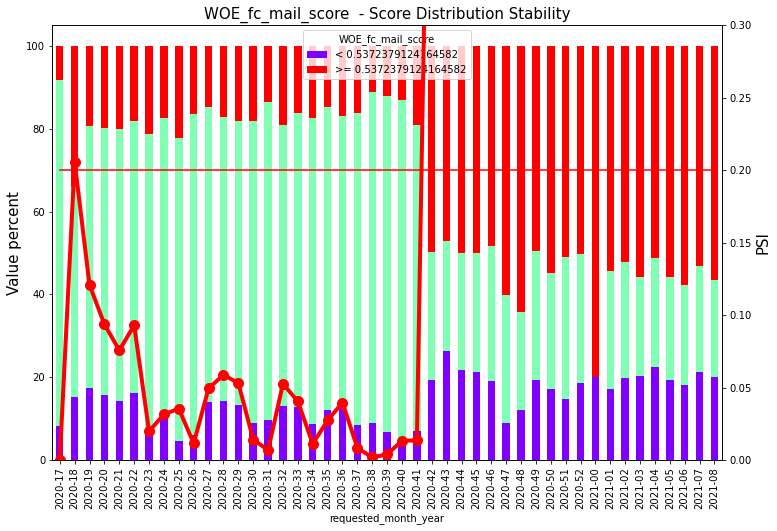

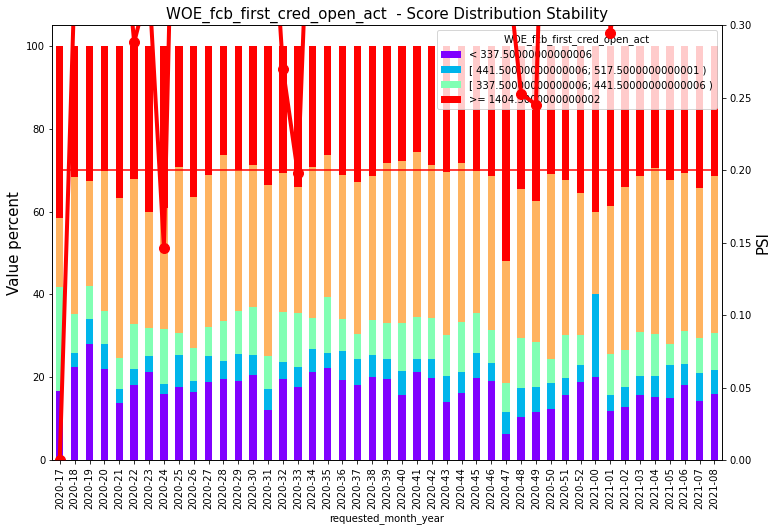

In [49]:
month_num = 0  # Номер месяца от которого отталкиваться в расчёте psi.
date_name = DATE  # имя столбца даты по которому делить на месяцы
features_of_model = population_stability(df3, ivs, feat, month_num=month_num, pic_folder=pic_folder, date_name=date_name)

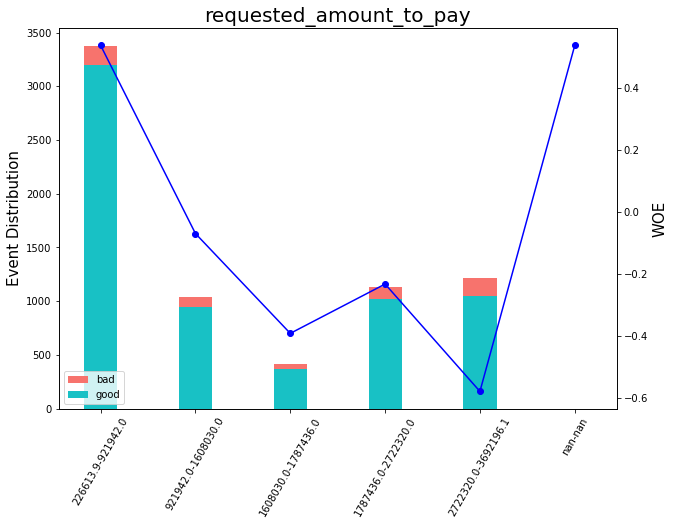

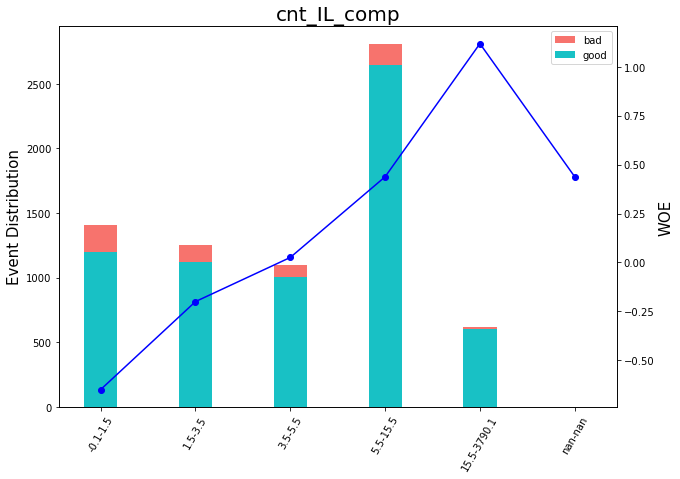

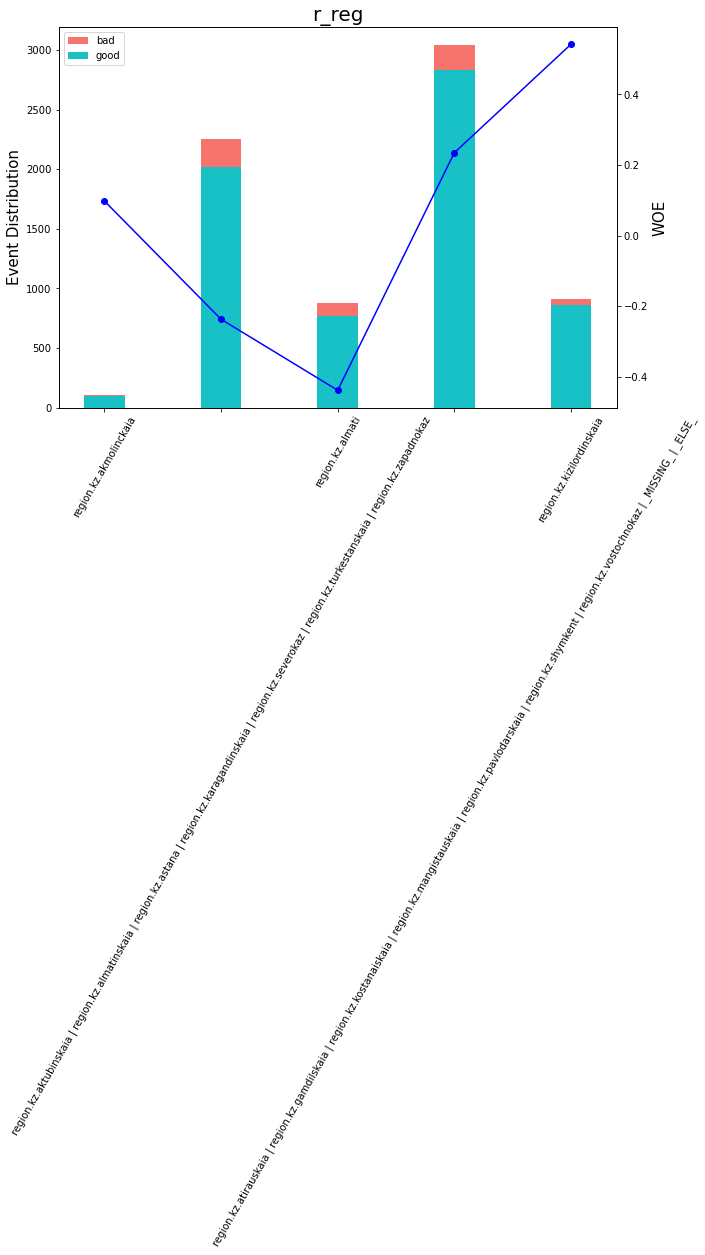

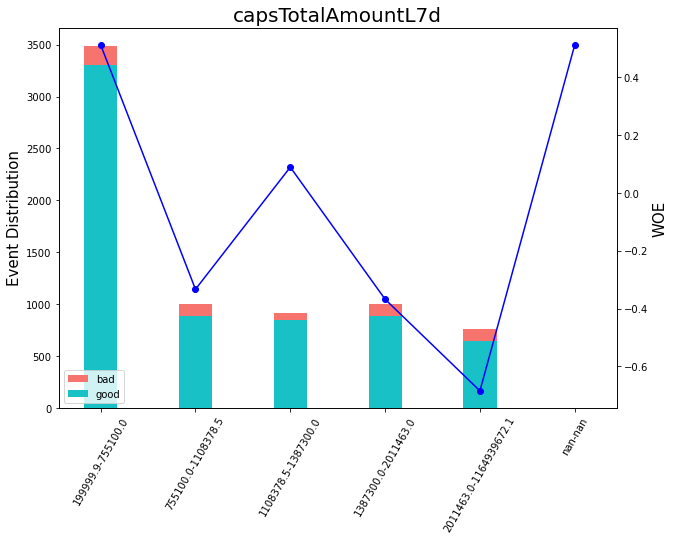

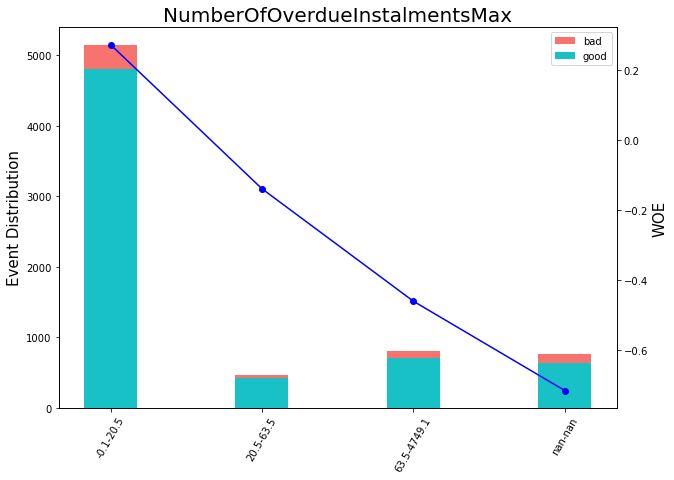

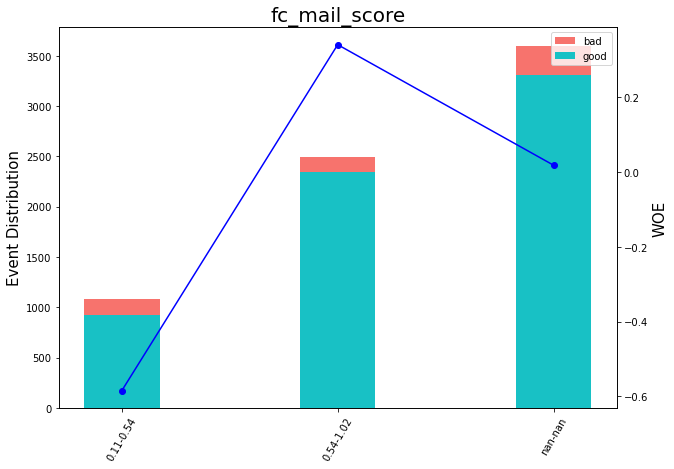

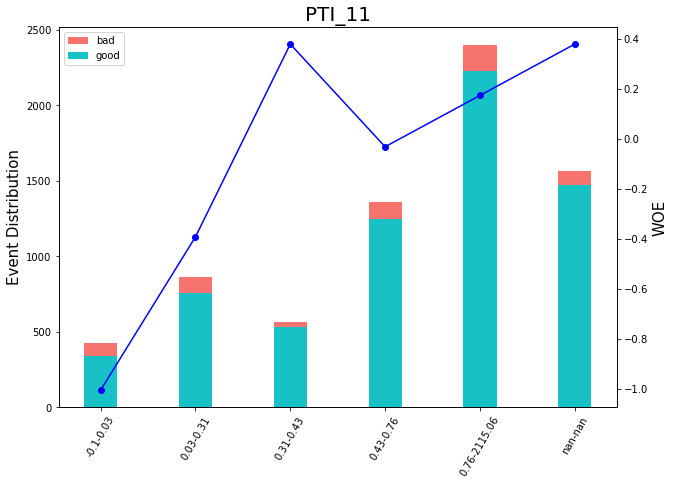

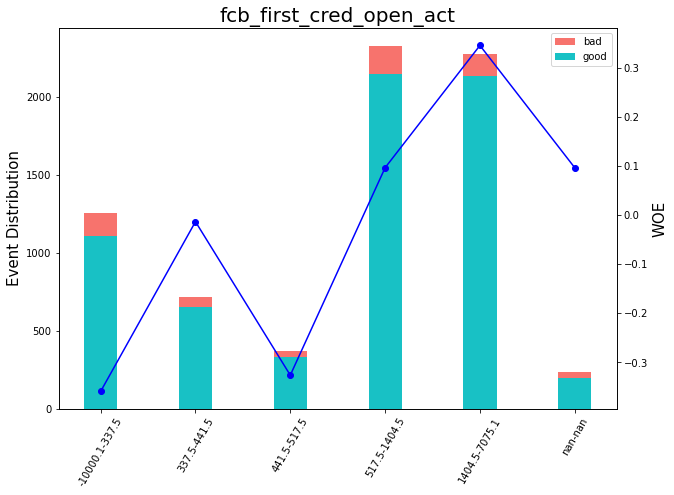

In [42]:
plot_all_bins(iv_df, X_train[vars_woe], pic_folder=pic_folder)

#### Корректировка биннинга
Если не треубется корректировать биннинг, то следующие 4 ячейки можно пропустить.

In [ ]:
vars_to_rebin = ['requested_amount_to_pay',
                 'capsTotalAmountL7d',
                 'fcb_first_cred_open_act',
                 'r_reg',]
for var in vars_to_rebin:
    print_feature_bins(var, iv_df)

'requested_amount_to_pay': [(226613.9, 921942.0), (921942.0, 1608030.0), (1608030.0, 1787436.0), (1787436.0, 2722320.0), (2722320.0, 3692196.1), ('nan', 'nan', 0.5361080556850151)],
'capsTotalAmountL7d': [(199999.9, 755100.0), (755100.0, 1108378.5), (1108378.5, 1387300.0), (1387300.0, 2011463.0), (2011463.0, 1164939672.1), ('nan', 'nan', 0.5124864696156477)],
'fcb_first_cred_open_act': [(-10000.1, 337.5), (337.5, 441.5), (441.5, 517.5), (517.5, 1404.5), (1404.5, 7075.1), ('nan', 'nan', 0.09620546923201265)],
'r_reg': ['region.kz.akmolinckaia', 'region.kz.aktubinskaia | region.kz.almatinskaia | region.kz.astana | region.kz.karagandinskaia | region.kz.severokaz | region.kz.turkestanskaia | region.kz.zapadnokaz', 'region.kz.almati', 'region.kz.atirauskaia | region.kz.gamdilskaia | region.kz.kostanaiskaia | region.kz.mangistauskaia | region.kz.pavlodarskaia | region.kz.shymkent | region.kz.vostochnokaz | _MISSING_ | _ELSE_', 'region.kz.kizilordinskaia'],


In [ ]:
new_bins = {
    'requested_amount_to_pay': [(226613.9, 921942.0), (921942.0, 1608030.0), (1608030.0, 2722320.0), (2722320.0, 3692196.1), ('nan', 'nan', 0.5361080556850151)],
    'capsTotalAmountL7d': [(199999.9, 755100.0), (755100.0, 1387300.0), (1387300.0, 2011463.0), (2011463.0, 1164939672.1), ('nan', 'nan', 0.5124864696156477)],
    'fcb_first_cred_open_act': [(-10000.1, 337.5), (337.5, 517.5), (517.5, 1404.5), (1404.5, 7075.1), ('nan', 'nan', 0.09620546923201265)],
    'r_reg': ['region.kz.aktubinskaia | region.kz.almatinskaia | region.kz.astana | region.kz.karagandinskaia | region.kz.severokaz | region.kz.turkestanskaia | region.kz.zapadnokaz', 'region.kz.almati', 'region.kz.atirauskaia | region.kz.gamdilskaia | region.kz.kostanaiskaia | region.kz.mangistauskaia | region.kz.pavlodarskaia | region.kz.shymkent | region.kz.vostochnokaz | region.kz.akmolinckaia | _MISSING_ | _ELSE_', 'region.kz.kizilordinskaia'],
}

new_iv_df = correct_binning_dict(new_bins, iv_df, df_train)

In [ ]:
# feature = 'requested_amount_to_pay'
feature = list(new_bins.keys())[0]
display(iv_df[iv_df['VAR_NAME'] == feature])
display(new_iv_df[new_iv_df['VAR_NAME'] == feature])

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,DR,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,WOE,IV
431,requested_amount_to_pay,226613.9,921942.0,3372,0.051008,172,0.284768,3200,0.486766,0.536108,0.200789
432,requested_amount_to_pay,921942.0,1608030.0,1037,0.089682,93,0.153974,944,0.143596,-0.069777,0.200789
433,requested_amount_to_pay,1608030.0,1787436.0,418,0.119617,50,0.082781,368,0.055978,-0.391244,0.200789
434,requested_amount_to_pay,1787436.0,2722320.0,1136,0.103873,118,0.195364,1018,0.154852,-0.232393,0.200789
435,requested_amount_to_pay,2722320.0,3692196.1,1215,0.140741,171,0.283113,1044,0.158807,-0.578152,0.200789
436,requested_amount_to_pay,NaN,NaN,0,0,0,0,0,0,0.536108,0.200789


,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,DR,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,WOE,IV
734,requested_amount_to_pay,226613.9,921942.0,3372,0.051008,172,0.284768,3200,0.486766,0.536108,0.199536
735,requested_amount_to_pay,921942.0,1608030.0,1037,0.089682,93,0.153974,944,0.143596,-0.069777,0.199536
736,requested_amount_to_pay,1608030.0,2722320.0,1554,0.108108,168,0.278146,1386,0.210831,-0.27709,0.199536
737,requested_amount_to_pay,2722320.0,3692196.1,1215,0.140741,171,0.283113,1044,0.158807,-0.578152,0.199536
738,requested_amount_to_pay,NaN,NaN,0,0.0,0,0.0,0,0.0,0.536108,0.199536


In [ ]:
# Сохраняем WOE таблицу для итоговых переменных с новым биннигом.
new_iv_df[new_iv_df['VAR_NAME'].isin(var_name_original(vars_woe))].to_excel('result/new_iv_df.xlsx', index=False)

# Если требуется запустить заново построение карты с новым биннингом,
# то лучше всего использовать отдельный jupyter notebook, в котором можно
# загрузить данный файл и произвести заново построение карты + расчет параметров для оценки.
# Если это не требуется, то можно продолжить построение итогового отчета в этом файле.

#### Формирование итогового excel файла

In [ ]:
model = sm.Logit(y_train, X_train[vars_woe])
model_fit = model.fit()
model_fit.pvalues

PV = pd.DataFrame(data=model_fit.pvalues, columns=['pv_train'])
PV = PV.sort_values(by='pv_train', ascending=False)
# PV.to_excel('results/pvalues.xlsx')

Optimization terminated successfully.
         Current function value: 0.582207
         Iterations 5


In [ ]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта Solva KZ сегмента street'

DSL = generate_DSL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')
SQL = generate_SQL(ivs, feat, nan_to_woe='max_cat', else_to_woe='max_cat')


clf_lr = logreg
name_2 = 'report/slkz_solvaStreet_score_v1.1'

export_to_excel(
    DSL=DSL,
    SQL=SQL,
    X_train=X_train[vars_woe],
    X_test=X_test[vars_woe],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3,
    iv_df=iv_df,
    ivs=ivs,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=feat,
    features_of_model=features_of_model,
    clf_lr=clf_lr,
    gini_by_vars=gini_by_vars,
    PV=PV,
    X_out=X_out[vars_woe],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description,
    date_name='date_requested'
)

Exported!
